In [478]:
import os
import datetime
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import  accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from tensorflow.keras import layers

# from ann_output import binary_ann_df

from utils import list_seasons, custom_accuracy_margin, accuracy_double_strict, accuracy_double_margin, confusion_classification
from download_data import download_league_season,download_fixtures,load_data,load_fixtures
from ann_utils import split_data, scale_datasets

# from mlp_classifier import mlp_model_fit

from predictables import table, table_bet, table_filter, table_pred

In [479]:
first_year = 18
bet_amount_base = 10
min_entropy = 0.5
max_entropy = 1.6

In [480]:
key = "E0"
leagues_keys = [key,"E1","F1","SP1","I1","D1"]#"SC0","SP1","F1","D1","I1"]

In [481]:
current_year = datetime.datetime.now().year
current_season = f"{current_year%100:02d}{current_year%100+1:02d}"

base_path = os.getcwd()
folder_path = os.path.join(base_path, "resources", "seasons")

existing_csv = {
    entry.name for entry in os.scandir(folder_path)
    if entry.is_file() and entry.name.endswith(".csv") and any(key in entry.name for key in leagues_keys)
}

venue_infos = ['Div','Date','Time','HomeTeam','AwayTeam']
odds = ['PSH','PSD','PSA']
columns_to_check = venue_infos + odds
result_cols = ['FTHG','FTAG','FTR'] #'HTR','HTHG','HTAG'
shot_cols = ['HS','AS','HST','AST']
card_cols = ['HR','AR']
usecols = venue_infos + result_cols + shot_cols + card_cols + odds
unique_key = False

In [482]:
filename = f"fixtures.csv" 
download_fixtures(os.path.join(base_path, "resources"), filename)
fixtures = load_fixtures(base_path, filename, columns_to_check, current_season, leagues_keys, unique_key=unique_key)

Download successful for next fixtures, filename: fixtures.csv


In [483]:
all_seasons = list_seasons(first_year=first_year, last_year=current_year)

for season in all_seasons:
    if unique_key:
        filename = f"{key}_{season}.csv" 
        if (filename not in existing_csv) or season == current_season:
            download_league_season(folder_path,filename,season,key)
    else:
        for k in leagues_keys:
            filename = f"{k}_{season}.csv" 
            if (filename not in existing_csv) or season == current_season:
                download_league_season(folder_path,filename,season,k)

Download successful for league: E0, season: 2324, filename: E0_2324.csv
Download successful for league: E1, season: 2324, filename: E1_2324.csv
Download successful for league: F1, season: 2324, filename: F1_2324.csv
Download successful for league: SP1, season: 2324, filename: SP1_2324.csv
Download successful for league: I1, season: 2324, filename: I1_2324.csv
Download successful for league: D1, season: 2324, filename: D1_2324.csv


In [484]:
league_data = load_data(folder_path, all_seasons, usecols, leagues_keys, unique_key=unique_key)

In [485]:
league_data['FTGD'] = league_data['FTHG'] - league_data['FTAG']

In [486]:
league_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12758 entries, 0 to 12757
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Div       12758 non-null  object        
 1   Season    12758 non-null  object        
 2   DateTime  12758 non-null  datetime64[ns]
 3   HomeTeam  12758 non-null  object        
 4   AwayTeam  12758 non-null  object        
 5   FTHG      12758 non-null  int64         
 6   FTAG      12758 non-null  int64         
 7   FTR       12758 non-null  object        
 8   HS        12757 non-null  float64       
 9   AS        12757 non-null  float64       
 10  HST       12757 non-null  float64       
 11  AST       12757 non-null  float64       
 12  HR        12757 non-null  float64       
 13  AR        12757 non-null  float64       
 14  PSH       12745 non-null  float64       
 15  PSD       12745 non-null  float64       
 16  PSA       12745 non-null  float64       
 17  FTGD      12

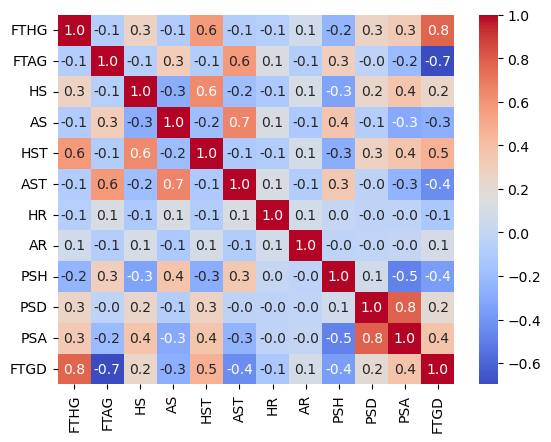

In [487]:
sns.heatmap(league_data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".1f")
plt.show()

In [488]:
league_data.describe()

,FTHG,FTAG,HS,AS,HST,AST,HR,AR,PSH,PSD,PSA,FTGD
count,12758.000000,12758.000000,12757.000000,12757.000000,12757.000000,12757.000000,12757.000000,12757.000000,12745.000000,12745.000000,12745.000000,12758.000000
mean,1.505408,1.222449,13.192365,11.005487,4.723446,3.938622,0.080662,0.097358,2.794575,4.019631,4.390101,0.282960
std,1.282082,1.145614,5.080706,4.637161,2.581933,2.324642,0.287723,0.313424,1.787948,1.179801,3.550942,1.784821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,2.080000,1.110000,-9.000000
25%,1.000000,0.000000,10.000000,8.000000,3.000000,2.000000,0.000000,0.000000,1.770000,3.380000,2.440000,-1.000000
50%,1.000000,1.000000,13.000000,10.000000,4.000000,4.000000,0.000000,0.000000,2.320000,3.640000,3.350000,0.000000
75%,2.000000,2.000000,16.000000,14.000000,6.000000,5.000000,0.000000,0.000000,3.120000,4.170000,4.940000,1.000000
max,9.000000,9.000000,46.000000,35.000000,20.000000,20.000000,3.000000,3.000000,22.560000,18.130000,42.940000,9.000000


In [489]:
alpha = 0.15
shift_val = 1
win_size = 4
seasons = league_data.groupby("Season")

Hcols = ['HPointsH','HGFH','HGCH','HSH','HSTH']
Acols = ['APointsA','AGFA','AGCA','ASA','ASTA']

seasonal_df = pd.DataFrame()
columns_to_check.remove('Date')
columns_to_check.remove('Time')
columns_to_check.insert(1,'Season')
columns_to_check.insert(2,'DateTime')
for season_label, season_df in seasons:    
    
    if season_label == current_season:
        # season_df = pd.concat([season_df, fixtures])
        temp_seas_merged_df = pd.merge(season_df, fixtures, on=columns_to_check, how='outer', indicator=True)
        unique_rows = temp_seas_merged_df[temp_seas_merged_df['_merge'] == 'right_only'].drop('_merge', axis=1)

        season_df = pd.concat([season_df, unique_rows], ignore_index=True)
        season_df = season_df.drop_duplicates(subset=columns_to_check, keep='first')

        
    # Home team statistics
    # season_df[['HGFH_m', 'HGCH_m']] = season_df.groupby('HomeTeam', group_keys=False)[['FTHG', 'FTAG']].apply(lambda x: x.shift(shift_val).expanding().mean())
    season_df['HPointsH'] = season_df.apply(lambda row: 3 if row['FTR'] == 'H' else 1 if row['FTR'] == 'D' else 0, axis=1)
    season_df['HPtsH_m'] = season_df.groupby('HomeTeam', group_keys=False)['HPointsH'].apply(lambda x: x.shift(shift_val).expanding().mean())
    # season_df[['HSH_m', 'HSTH_m']] = season_df.groupby('HomeTeam', group_keys=False)[['HS', 'HST']].apply(lambda x: x.shift(shift_val).expanding().mean())
    # season_df['HPtsH_e'] = season_df.groupby('HomeTeam', group_keys=False)['HPointsH'].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())
    
    # Away team statistics
    # season_df[['AGFA_m', 'AGCA_m']] = season_df.groupby('AwayTeam', group_keys=False)[['FTAG', 'FTHG']].apply(lambda x: x.shift(shift_val).expanding().mean())
    season_df['APointsA'] = season_df.apply(lambda row: 3 if row['FTR'] == 'A' else 1 if row['FTR'] == 'D' else 0, axis=1)
    season_df['APtsA_m'] = season_df.groupby('AwayTeam', group_keys=False)['APointsA'].apply(lambda x: x.shift(shift_val).expanding().mean())
    # season_df[['ASA_m', 'ASTA_m']] = season_df.groupby('AwayTeam', group_keys=False)[['AS', 'AST']].apply(lambda x: x.shift(shift_val).expanding().mean())
    # season_df['APtsA_e'] = season_df.groupby('AwayTeam', group_keys=False)['APointsA'].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())

    seasonal_df = pd.concat([seasonal_df, season_df]).reset_index(drop=True)

In [490]:
fixtures = seasonal_df.copy()[(seasonal_df['FTHG'].isna()) & (seasonal_df['FTAG'].isna()) & (seasonal_df['FTR'].isna())][columns_to_check]

In [491]:
fixtures

,Div,Season,DateTime,HomeTeam,AwayTeam,PSH,PSD,PSA
12758,E1,2324,2023-12-12 19:45:00,Blackburn,Bristol City,1.98,3.79,3.84
12759,E1,2324,2023-12-12 19:45:00,Huddersfield,Preston,2.78,2.99,3.00
12760,E1,2324,2023-12-12 19:45:00,Rotherham,West Brom,5.51,3.76,1.71
12761,E1,2324,2023-12-12 19:45:00,Stoke,Swansea,2.12,3.63,3.56
12762,E1,2324,2023-12-12 19:45:00,Watford,Ipswich,3.03,3.49,2.43
12763,E1,2324,2023-12-12 20:00:00,Sunderland,Leeds,2.88,3.67,2.45
12764,E1,2324,2023-12-13 19:45:00,Cardiff,Birmingham,1.90,3.59,4.45
12765,E1,2324,2023-12-13 19:45:00,Coventry,Southampton,2.75,3.53,2.62
12766,E1,2324,2023-12-13 19:45:00,Leicester,Millwall,1.35,5.31,9.90
12767,E1,2324,2023-12-13 19:45:00,Norwich,Sheffield Weds,1.97,3.64,4.05


In [492]:
seasons_chps = seasonal_df.groupby(['Div','Season'])
for _, dataframe in seasons_chps:
    nb_upcoming_games = len(dataframe[(dataframe['FTHG'].isna()) & (dataframe['FTAG'].isna()) & (dataframe['FTR'].isna())])
    nb_games_data = len(dataframe) - nb_upcoming_games
    dataframe['period'] = dataframe.reset_index().index + 1    

    dataframe['DivHGF_avg'] = dataframe['FTHG'].cumsum().shift(1)/dataframe['period']
    dataframe['DivAGF_avg'] = dataframe['FTAG'].cumsum().shift(1)/dataframe['period']
    dataframe['DivHGF_avg'] = dataframe['DivHGF_avg'].fillna(method='ffill')
    dataframe['DivAGF_avg'] = dataframe['DivAGF_avg'].fillna(method='ffill')

    mask = (seasonal_df['Div'] == dataframe['Div'].iloc[0]) & (seasonal_df['Season'] == dataframe['Season'].iloc[0])
    seasonal_df.loc[mask, ['DivHGF_avg', 'DivAGF_avg']] = dataframe[['DivHGF_avg', 'DivAGF_avg']]

In [496]:
chps = seasonal_df.groupby('Div')
for _, dataframe in chps:
    nb_upcoming_games = len(dataframe[(dataframe['FTHG'].isna()) & (dataframe['FTAG'].isna()) & (dataframe['FTR'].isna())])
    nb_games_data = len(dataframe) - nb_upcoming_games
    dataframe['period'] = dataframe.reset_index().index + 1
    dataframe['period'] = np.where(dataframe['period'] < 40, dataframe['period'], 40)
    dataframe['DivHGF_r'] = dataframe['FTHG'].shift(shift_val).rolling(window=40, min_periods=5).sum()
    dataframe['DivAGF_r'] = dataframe['FTAG'].shift(shift_val).rolling(window=40, min_periods=5).sum()
    dataframe['DivHGF_ravg'] = dataframe['DivHGF_r'].rolling(window=40, min_periods=1).mean()/dataframe['period']
    dataframe['DivAGF_ravg'] = dataframe['DivAGF_r'].rolling(window=40, min_periods=1).mean()/dataframe['period']

    dataframe['DivHGF_ravg'] = dataframe['DivHGF_ravg'].fillna(method='ffill')
    dataframe['DivAGF_r'] = dataframe['DivAGF_r'].fillna(method='ffill')
    
    mask = (seasonal_df['Div'] == dataframe['Div'].iloc[0])
    seasonal_df.loc[mask, ['DivHGF_ravg', 'DivAGF_ravg']] = dataframe[['DivHGF_ravg', 'DivAGF_ravg']]
    
    print(_,nb_upcoming_games,nb_games_data)

D1 0 1655
E0 0 2060
E1 12 3000
F1 0 1934
I1 0 2050
SP1 0 2059


In [498]:
seasonal_df[seasonal_df['Div']=='E1'].tail(25)

,Div,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,...,PSA,FTGD,HPointsH,HPtsH_m,APointsA,APtsA_m,DivHGF_avg,DivAGF_avg,DivHGF_ravg,DivAGF_ravg
12663,E1,2324,2023-12-03 13:30:00,Bristol City,Norwich,1.0,2.0,A,15.0,12.0,...,3.19,-1.0,0,1.555556,3,0.888889,1.521930,1.236842,1.588125,1.219375
12700,E1,2324,2023-12-08 20:00:00,Coventry,Birmingham,2.0,0.0,H,16.0,13.0,...,5.01,2.0,3,1.555556,0,0.444444,1.519651,1.240175,1.592500,1.220625
12704,E1,2324,2023-12-09 12:30:00,Blackburn,Leeds,0.0,2.0,A,12.0,8.0,...,1.77,-2.0,0,1.333333,3,1.555556,1.521739,1.234783,1.596250,1.220625
12705,E1,2324,2023-12-09 12:30:00,Sunderland,West Brom,2.0,1.0,H,14.0,11.0,...,3.33,1.0,3,1.666667,0,1.333333,1.515152,1.238095,1.600625,1.221875
12714,E1,2324,2023-12-09 15:00:00,Watford,Southampton,1.0,1.0,D,11.0,6.0,...,2.31,0.0,1,1.800000,1,1.888889,1.517241,1.237069,1.603750,1.220625
12718,E1,2324,2023-12-09 15:00:00,Stoke,Sheffield Weds,0.0,1.0,A,13.0,6.0,...,4.08,-1.0,0,1.444444,3,0.111111,1.515021,1.236052,1.608750,1.221250
12719,E1,2324,2023-12-09 15:00:00,Cardiff,Millwall,1.0,0.0,H,7.0,10.0,...,3.85,1.0,3,1.777778,0,1.444444,1.508547,1.235043,1.613750,1.221250
12720,E1,2324,2023-12-09 15:00:00,Huddersfield,Bristol City,1.0,1.0,D,6.0,15.0,...,2.49,0.0,1,1.111111,1,1.222222,1.506383,1.229787,1.619375,1.218750
12721,E1,2324,2023-12-09 15:00:00,Leicester,Plymouth,4.0,0.0,H,13.0,15.0,...,9.88,4.0,3,2.333333,0,0.333333,1.504237,1.228814,1.623750,1.214375
12722,E1,2324,2023-12-09 15:00:00,Middlesbrough,Ipswich,0.0,2.0,A,7.0,9.0,...,2.91,-2.0,0,1.777778,3,2.000000,1.514768,1.223629,1.630000,1.210625


In [313]:
seasonal_df[['HGFH_r', 'HGCH_r', 'HPtsH_r']] = seasonal_df.groupby('HomeTeam', group_keys=False)[['FTHG', 'FTAG', 'HPointsH']].apply(lambda x: x.shift(shift_val).rolling(window=win_size, min_periods=1).mean())
seasonal_df[['AGFA_r', 'AGCA_r', 'APtsA_r']] = seasonal_df.groupby('AwayTeam', group_keys=False)[['FTAG', 'FTHG', 'APointsA']].apply(lambda x: x.shift(shift_val).rolling(window=win_size, min_periods=1).mean())


seasonal_df[['HGFH_e', 'HGCH_e', 'HSH_e', 'HSTH_e']] = seasonal_df.groupby('HomeTeam', group_keys=False)[['FTHG', 'FTAG', 'HS', 'HST']].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())
seasonal_df[['AGFA_e', 'AGCA_e', 'ASA_e', 'ASTA_e']] = seasonal_df.groupby('AwayTeam', group_keys=False)[['FTAG', 'FTHG', 'AS', 'AST']].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())

seasonal_df = seasonal_df.drop(['HPointsH','APointsA'],axis=1)

In [ ]:
teams = sorted(set(seasonal_df['HomeTeam'].unique()) | set(seasonal_df['AwayTeam'].unique()))
# seasons = seasonal_df.groupby("Season")

In [ ]:
joint_cols = ["GF","GC","SF","SC","STF","STC","Pts"]

for col in joint_cols:
    seasonal_df[f"H{col}"] = 0
    seasonal_df[f"A{col}"] = 0
    # seasonal_df[f"H{col}_r"] = 0
    # seasonal_df[f"A{col}_r"] = 0

In [ ]:
# joint_cols = ["Team","GF","GC","SF","SC","STF","STC"]
# for season_label, season_df in seasons:
#     season_teams = sorted(set(season_df['HomeTeam'].unique()) | set(season_df['AwayTeam'].unique()))
#     for team in season_teams:
#         team_stats = pd.DataFrame(columns=joint_cols)
#         team_homes = season_df[season_df["HomeTeam"] == team][['HomeTeam','FTHG','FTAG','HS','AS','HST','AST']]
#         team_aways = season_df[season_df["AwayTeam"] == team][['AwayTeam','FTAG','FTHG','AS','HS','AST','HST']]
#         team_homes = team_homes.rename(columns=dict(zip(team_homes.columns, joint_cols)))
#         team_aways = team_aways.rename(columns=dict(zip(team_aways.columns, joint_cols)))

#         team_stats = pd.concat([team_homes, team_aways])
#         team_stats = team_stats.sort_index()
        
#         team_stats[['GF_m', 'GC_m']] = team_stats.groupby('Team', group_keys=False)[['GF', 'GC']].apply(lambda x: x.shift(shift_val).expanding().mean())
#         team_stats['Points'] = team_stats.apply(lambda row: 3 if row['GF'] > row['GC'] else 1 if row['GF'] == row['GC'] else 0, axis=1)
#         team_stats['Pts_m'] = team_stats.groupby('Team', group_keys=False)['Points'].apply(lambda x: x.shift(shift_val).expanding().mean())
    
    
#         print(team_stats)

In [ ]:
for team in teams:
    columns = ["Team","Opponent"]+joint_cols
    team_stats = pd.DataFrame(columns=columns)
    team_homes = seasonal_df[seasonal_df["HomeTeam"] == team][['HomeTeam','AwayTeam','FTHG','FTAG','HS','AS','HST','AST']]
    team_aways = seasonal_df[seasonal_df["AwayTeam"] == team][['AwayTeam','HomeTeam','FTAG','FTHG','AS','HS','AST','HST']]
    team_homes = team_homes.rename(columns=dict(zip(team_homes.columns, columns)))
    team_homes['HomeTeam'] = team_homes['Team']
    team_homes['AwayTeam'] = team_homes['Opponent']
    team_aways = team_aways.rename(columns=dict(zip(team_aways.columns, columns)))
    team_aways['AwayTeam'] = team_homes['Team']
    team_aways['HomeTeam'] = team_homes['Opponent']

    team_stats = pd.concat([team_homes, team_aways])
    team_stats = team_stats.sort_index()
    
    team_stats['Points'] = team_stats.apply(lambda row: 3 if row['GF'] > row['GC'] else 1 if row['GF'] == row['GC'] else 0, axis=1)
    team_stats['Pts_r'] = team_stats.groupby('Team', group_keys=False)['Points'].apply(lambda x: x.shift(shift_val).rolling(window=win_size, min_periods=1).mean())
    
    team_stats[['GF_r', 'GC_r']] = team_stats.groupby('Team', group_keys=False)[['GF', 'GC']].apply(lambda x: x.shift(shift_val).rolling(window=win_size, min_periods=1).mean())
    team_stats[['SF_r', 'STF_r', 'SC_r', 'STC_r']] = team_stats.groupby('Team', group_keys=False)[['SF', 'STF', 'SC', 'STC']].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())

    team_stats[['GF_e', 'GC_e']] = team_stats.groupby('Team', group_keys=False)[['GF', 'GC']].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())
    team_stats[['SF_e', 'STF_e', 'SC_e', 'STC_e']] = team_stats.groupby('Team', group_keys=False)[['SF', 'STF', 'SC', 'STC']].apply(lambda x: x.shift(shift_val).ewm(alpha=alpha, adjust=False).mean())
    
    merge_cols = ['Team','GF_e', 'GC_e', 'SF_e', 'SC_e', 'STF_e', 'STC_e', 'Pts_r']
    merge_df = team_stats[merge_cols]
    
    mask_home_stats = (merge_df['Team'] == team_stats['HomeTeam'])
    mask_away_stats = ~mask_home_stats
    
    home_cols = [f"H{col}" for col in joint_cols]
    away_cols = [f"A{col}" for col in joint_cols]
        
    mask_home_df = mask_home_stats.reindex(seasonal_df.index, fill_value=False)
    mask_away_df = mask_away_stats.reindex(seasonal_df.index, fill_value=False)

    seasonal_home_idx = seasonal_df[mask_home_df].index
    team_stats_home_idx = team_stats[mask_home_stats].index
    seasonal_df.loc[seasonal_home_idx, home_cols] = team_stats.loc[team_stats_home_idx, merge_cols[1:]].values

    seasonal_away_idx = seasonal_df[mask_away_df].index
    team_stats_away_idx = team_stats[mask_away_stats].index
    seasonal_df.loc[seasonal_away_idx, away_cols] = team_stats.loc[team_stats_away_idx, merge_cols[1:]].values


In [ ]:
def fill_nan_with_avg_last_4(series):
    return series.fillna(series.rolling(window=win_size, min_periods=1).mean())

In [ ]:
team_homes = seasonal_df.groupby("HomeTeam")
team_aways = seasonal_df.groupby("AwayTeam")

for name, group in team_homes:
    seasonal_df.loc[group.index, group.columns.str.contains('_m')] = group.loc[:, group.columns.str.contains('_m')].apply(fill_nan_with_avg_last_4)

for name, group in team_aways:
    seasonal_df.loc[group.index, group.columns.str.contains('_m')] = group.loc[:, group.columns.str.contains('_m')].apply(fill_nan_with_avg_last_4)



In [ ]:
no_drop_columns = result_cols + shot_cols + card_cols +['FTGD'] #'HTHG','HTAG','HTR',
features_df = seasonal_df.dropna(subset=[col for col in seasonal_df.columns if col not in no_drop_columns]).copy()

In [ ]:
features_df.info()

## CREATE 'SURPRISE' feature, 'robust' feature (ability not to lose even dominated)

    use final result, shots, odds
    for example: if team with very high odd wins : can be seen as outlier

    + add evidence with game stats that not the team dominating always win (without FHTG, FTAG)

In [ ]:
features_df['HoffStr'] = features_df['HGF'] + features_df['AGCA_e'] + features_df['HGFH_e'] + features_df['AGC']
features_df['AoffStr'] = features_df['AGF'] + features_df['HGCH_e'] + features_df['AGFA_e'] + features_df['HGC']
features_df['ShDiff'] = features_df['HSF'] + features_df['HSH_e'] - features_df['ASF'] - features_df['ASA_e']
features_df['ShtDiff'] = features_df['HSTF'] + features_df['HSTH_e'] - features_df['ASTF'] - features_df['ASTA_e']

features_df['GFdiff'] = features_df['HGF'] + features_df['HGFH_e'] - features_df['AGF'] - features_df['AGFA_e']
features_df['GCdiff'] = features_df['HGC'] + features_df['HGCH_e'] - features_df['AGC'] - features_df['AGCA_e']

features_df['PCH'] = features_df['HGFH_e'] + features_df['HSH_e'] + features_df['AGCA_e']
features_df['PCA'] = features_df['AGFA_e'] + features_df['ASA_e'] + features_df['HGCH_e']

features_df['PCdiff'] = features_df['PCH']  - features_df['PCA'] 
features_df['Ptsdiff'] = features_df['HPts']  - features_df['APts'] 

In [ ]:
# features_df['BTTS'] = features_df.apply(lambda row: 1 if row['FTHG'] > 0 and row['FTAG'] > 0 else 0, axis=1)

# features_df['2more1'] = features_df.apply(lambda row: 1 if (row['FTHG'] + row['FTAG'] - row['HTHG'] + row['HTAG']) > (row['HTHG'] + row['HTAG']) else 0, axis=1)

# features_df['over15'] = features_df.apply(lambda row: 1 if row['FTHG'] + row['FTAG'] > 1.5 else 0, axis=1)
# features_df['over25'] = features_df.apply(lambda row: 1 if row['FTHG'] + row['FTAG'] > 2.5 else 0, axis=1)
# features_df['over35'] = features_df.apply(lambda row: 1 if row['FTHG'] + row['FTAG'] > 3.5 else 0, axis=1)

# features_df['Hover05'] = features_df.apply(lambda row: 1 if row['FTHG'] > 0.5 else 0, axis=1)
# features_df['Hover15'] = features_df.apply(lambda row: 1 if row['FTHG'] > 1.5 else 0, axis=1)
# features_df['Hover25'] = features_df.apply(lambda row: 1 if row['FTHG'] > 2.5 else 0, axis=1)
# features_df['Hover35'] = features_df.apply(lambda row: 1 if row['FTHG'] > 3.5 else 0, axis=1)

# features_df['Aover05'] = features_df.apply(lambda row: 1 if row['FTAG'] > 0.5 else 0, axis=1)
# features_df['Aover15'] = features_df.apply(lambda row: 1 if row['FTAG'] > 1.5 else 0, axis=1)
# features_df['Aover25'] = features_df.apply(lambda row: 1 if row['FTAG'] > 2.5 else 0, axis=1)
# features_df['Aover35'] = features_df.apply(lambda row: 1 if row['FTAG'] > 3.5 else 0, axis=1)

In [ ]:
features_df['H'] = (features_df['FTR'] == 'H').astype(int)
features_df['D'] = (features_df['FTR'] == 'D').astype(int)
features_df['A'] = (features_df['FTR'] == 'A').astype(int)


sns.heatmap(features_df[['HSH_m','HPtsH_m','HPts','HGF','HGFH_e','AGC','HoffStr','HSH_e','HSF','PCH','FTHG']].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.show() #HPtsH_e

In [ ]:
sns.heatmap(features_df[['ASA_m','APtsA_m','APts','AGF','AGFA_e','HGCH_e','HGC','HGCH_e','ASA_e','ASF','PCA','FTAG']].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.show() #APtsA_e

In [ ]:
sns.heatmap(features_df[['ShDiff','ShtDiff', 'GFdiff','GCdiff','PCdiff','Ptsdiff','HoffStr','AoffStr','FTGD']].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.show() #APtsA_e

In [ ]:
over_cols = [col for col in features_df.columns.tolist() if 'over' in col]

df_cols = features_df.columns.tolist()

game_infos =['Div','DateTime','HomeTeam','AwayTeam'] + result_cols + card_cols # 'BTTS','2more1']

# input_features  = ['AGCA_e','HSH_e','HSF', #'HPts', #'HPtsH_m', 'HPts', 'PCH',
#                    'HGCH_e','ASA_e','ASF', #'APts',#'APtsA_m', 'APts','PCA',
#                    'ShtDiff','GFdiff','HoffStr', 'AoffStr'#'ShDiff'
#                    ]

# input_features  = ['HSF','HPtsH_m','HSTC', #'HPtsH_m', 'HPts', 'PCH',
#                    'ASF','APtsA_m','ASTC', #'APtsA_m', 'APts','PCA',
#                    'ShDiff',#,'GCdiff'
#                    ]

# input_features  = ['ShtDiff']

# sns.heatmap(features_df[input_features+['FTGD']].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
# plt.show() #APtsA_e

In [ ]:
all_features = df_cols[18:]
all_features.remove('H')
all_features.remove('D')
all_features.remove('A')
all_features.remove('ShDiff')
all_features.remove('ShtDiff')
all_features.remove('GCdiff')
all_features.remove('ASF')
all_features.remove('GFdiff')
all_features.remove('ASTA_m')
#'PCdiff','HSTH_m','HSH_e',

best_test_acc = 0
best_feature = ''
for feature in all_features:
    input_features  = ['ShDiff','ShtDiff','GCdiff','ASF','GFdiff','ASTA_m',feature]
    selected_features = game_infos + over_cols + input_features + odds


    data = features_df.copy()[selected_features]
    data['R'] = data['FTR'].map({'H': 1, 'D': 0, 'A': 2})


    target = 'R'
    test_size = 1000#len(leagues_keys)*36

    X_train,y_train,meta_train,X_test,y_test,meta_test,X_pred,meta_pred = split_data(data,fixtures,test_size,game_infos,over_cols,odds,target, no_red = False)
    X_train_scaled,X_test_scaled,X_pred_scaled = scale_datasets(X_train,X_test,X_pred)

    test_size = len(y_test)

    num_classes = len(np.unique(y_train))


    ann_model = keras.Sequential([
        layers.Dense(2**5, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(2**5, activation='relu'),
        # layers.Dense(2**3, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
    ])

    ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = ann_model.fit(X_train_scaled, keras.utils.to_categorical(y_train, num_classes=num_classes),
            epochs=10, batch_size=2**6, validation_data=(X_test_scaled, keras.utils.to_categorical(y_test, num_classes=num_classes)), verbose = 0)


    loss, accuracy = ann_model.evaluate(X_test_scaled, keras.utils.to_categorical(y_test, num_classes=num_classes))
    train_accuracy = history.history['accuracy'][-1]

    print(f"feature: {feature}")
    print(f'Loss on Test Set: {loss}')
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Accuracy on Test Set: {accuracy}')
    if accuracy >= best_test_acc:
        best_test_acc = accuracy
        best_feature = feature
        print('new best')


        

In [ ]:
best_feature,best_test_acc

In [ ]:
first_layer_weights = ann_model.layers[0].get_weights()[0]

feature_importances = np.sum(np.abs(first_layer_weights), axis=1)

feature_importances /= np.sum(feature_importances)

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [input_features[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=45, ha='right')  # Rotate feature names for better visibility
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Feature Importances in the First Layer')
plt.tight_layout()
plt.show()

In [ ]:
ann_train_proba = ann_model.predict(X_train_scaled)
ann_pred_proba = ann_model.predict(X_pred_scaled)

probh_ann = ann_pred_proba[:, 1]
probd_ann = ann_pred_proba[:, 0]
proba_ann = ann_pred_proba[:, 2]

# result_df_ann = table(probh_ann,probd_ann,proba_ann,meta_test,meta_pred,min_entropy,max_entropy)
# confusion_classification(result_df_ann, test_size)

-------

### MLP

In [ ]:
def mlp_model_fit(X_train_scaled,y_train):
    
    mlp_model = MLPClassifier(activation='relu', 
                              max_iter=800,
                              random_state=42)
    
    param_grid = {'hidden_layer_sizes':[(2**3,2**3)],
                  } #0.005,

    grid_search_mlp = GridSearchCV(mlp_model, param_grid, cv=5, scoring='accuracy', verbose=3, return_train_score=True)
    grid_search_mlp.fit(X_train_scaled, y_train)

    print("Best Parameters for MLP:")
    print(grid_search_mlp.best_params_)
    best_mlp = grid_search_mlp.best_estimator_
    

    return best_mlp.fit(X_train_scaled, y_train)


In [ ]:
mlp_model = mlp_model_fit(X_train_scaled,y_train)

In [ ]:
mlp_train_proba = mlp_model.predict_proba(X_train_scaled)
mlp_pred_proba =  mlp_model.predict_proba(X_pred_scaled)
accuracy_mlp = accuracy_score(y_test, np.argmax(mlp_pred_proba[:test_size], axis=1))
print(f'Accuracy on Test Set (MLP): {accuracy_mlp}')

In [ ]:
probh_mlp,probd_mlp,proba_mlp = mlp_pred_proba[:, 1],mlp_pred_proba[:, 0],mlp_pred_proba[:, 2]

# result_df_mlp = table(probh_mlp,probd_mlp,proba_mlp,meta_test,meta_pred,min_entropy,max_entropy)
# confusion_classification(result_df_mlp, test_size)

---

Random Forest Classifier

In [ ]:
params = {
    # 'n_estimators':30,
    'criterion': 'gini',
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,'max_features': 'sqrt','max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'oob_score': False,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': 0,'warm_start': False, 'class_weight': None,
}

rfc = RandomForestClassifier(**params)

param_grid = {
    'max_depth': [6]
}

grid_search_rfc = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
grid_search_rfc.fit(X_train_scaled, y_train)

best_rfc = grid_search_rfc.best_estimator_

In [ ]:
print("Best Parameters for RFC:")
print(grid_search_rfc.best_params_)

best_rfc.fit(X_train_scaled, y_train)

calibrated_model = CalibratedClassifierCV(best_rfc, cv='prefit', method='isotonic')
calibrated_model.fit(X_train_scaled, y_train)

predictions_rfc = calibrated_model.predict(X_test_scaled)

accuracy_rfc = accuracy_score(y_test, predictions_rfc)
print("Accuracy on test set: ", accuracy_rfc)

In [ ]:
rfc_train_proba = calibrated_model.predict_proba(X_train_scaled)
rfc_pred_proba = calibrated_model.predict_proba(X_pred_scaled)

In [ ]:
probh_rfc,probd_rfc,proba_rfc = rfc_pred_proba[:, 1],rfc_pred_proba[:, 0],rfc_pred_proba[:, 2]

--------------

### Ensemble Learning

In [ ]:
train_stack = np.column_stack((ann_train_proba, mlp_train_proba,rfc_train_proba))#combined_books

lr_model_train = LogisticRegression()
lr_model_train.fit(train_stack, y_train)

logis_train_pred = lr_model_train.predict(train_stack)
logis_train_prob = lr_model_train.predict_proba(train_stack)

probh = logis_train_prob[:,1]
probd = logis_train_prob[:,0]
proba = logis_train_prob[:,2]

accuracy_lr_train = accuracy_score(y_train, logis_train_pred)
accuracy_lr_train

In [ ]:
coefficients = lr_model_train.coef_[0]
feature_names = ['annh','annd','anna','mlph','mlpd','mlpa', 'rfch','rfcd','rfca']

# Create a dictionary to associate feature names with their coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the features by their absolute coefficient values to see the most influential ones
sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the sorted features and their coefficients
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient}")

In [ ]:
# result_train = pd.DataFrame({
#         'Home': probh,
#         'Draw': probd,
#         'Away': proba
#     })


# result_train['pred'] = np.where((result_train['Draw'] > result_train['Home']) & (result_train['Draw'] > result_train['Away']), 'D',
#                         np.where(result_train['Home'] > result_train['Away'], 'H', 'A'))

# result_train = pd.concat([meta_train, result_train], axis=1)

# result_train['prop entropy'] = result_train[['Home', 'Draw', 'Away']].apply(lambda x: (-np.sum(x * np.log2(x + 1e-12))-min_entropy)/ (max_entropy-min_entropy), axis=1)
# result_train['Bprob'] = result_train[['Home', 'Draw', 'Away']].max(axis=1)
# result_train['Odd'] = np.where(result_train['pred'] == 'H', result_train['PSH'],
#                                 np.where(result_train['pred'] == 'D', result_train['PSD'], result_train['PSA']))

In [ ]:
scaler = MinMaxScaler()
coef = 2

probh_square = probh_mlp**coef+probh_rfc**coef+probh_ann**coef
probd_square = probd_mlp**coef+probd_rfc**coef+probd_ann**coef
proba_square = proba_mlp**coef+proba_rfc**coef+proba_ann**coef

combined_square = np.column_stack((proba_square, probd_square, probh_square))
combined_square = scaler.fit_transform(combined_square)

bookiesh = 1/features_df[-(test_size+len(fixtures)):]['PSH']
bookiesd = 1/features_df[-(test_size+len(fixtures)):]['PSD']
bookiesa = 1/features_df[-(test_size+len(fixtures)):]['PSA']
combined_books= np.column_stack((proba_square, probd_square, probh_square))
combined_books = scaler.fit_transform(combined_books)

# square_preds = np.argmax(square_norms, axis=1)
preds_stack = np.column_stack((rfc_pred_proba,ann_pred_proba, mlp_pred_proba))#combined_square,combined_books

In [ ]:
acc_last = len(leagues_keys)*20

lr_model = LogisticRegression()
lr_model.fit(preds_stack[:test_size], y_test)

logis_preds = lr_model_train.predict(preds_stack)
logis_proba = lr_model_train.predict_proba(preds_stack)

probh = logis_proba[:,1]
probd = logis_proba[:,0]
proba = logis_proba[:,2]

accuracy_lr = accuracy_score(y_test, logis_preds[:test_size])
accuracy_last10 = accuracy_score(y_test[-acc_last:], logis_preds[test_size-acc_last:test_size])

f"accuracy last {test_size} : {accuracy_lr}, accuracy last {acc_last} : {accuracy_last10}"

In [ ]:
threshold_value = 0.055

In [ ]:
df_margin , accuracy_margin = custom_accuracy_margin(y_test, logis_proba[:test_size], threshold=threshold_value)
df_double_chance_strict , accuracy_double = accuracy_double_strict(y_test, logis_proba[:test_size], threshold=threshold_value)
df_double_chance_margin , accuracy_double_marg = accuracy_double_margin(y_test, logis_proba[:test_size], threshold=threshold_value)
print(f"accuracy_margin with threshold {threshold_value}: {accuracy_margin}")
print(f"accuracy_double without margin {threshold_value}: {accuracy_double}")
print(f"accuracy_double_margin with threshold {threshold_value}: {accuracy_double_marg}")


In [ ]:
# condition = (df['Diff Condition 1'] == True) | (df['Diff Condition 2'] == True)
# condition = (df['True Class'] == df['Second Prediction'])
# condition = (df['True Class'] != df['Predicted Class']) & (df['True Class'] != df['Second Prediction'])

# df[condition]

In [ ]:
coefficients = lr_model.coef_[0]
feature_names = ['annh','annd','anna','mlph','mlpd','mlpa', 'rfch','rfcd','rfca','squareh','squared','squarea']

# Create a dictionary to associate feature names with their coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the features by their absolute coefficient values to see the most influential ones
sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the sorted features and their coefficients
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient}")

In [ ]:
result = table(probh,probd,proba,meta_test,meta_pred,min_entropy,max_entropy).copy()

In [ ]:
np.round(result.tail(20),2)

In [ ]:
confusion_classification(result, test_size)

In [ ]:
result_bet_df = table_bet(result,bet_amount_base)

total_hypothetical_winnings = result_bet_df['result'].head(test_size).sum()
print(f"Total Hypothetical Winnings: {round(total_hypothetical_winnings,2)} euros over {len(result_bet_df[:test_size])} games (with total bet : {result_bet_df[:test_size]['base_bet'].sum()}€)")

In [ ]:
pred_table = table_pred(result,len(meta_pred))
pred_table['|'] = "|"
pred_table['Hodd'] = 1/pred_table['Home']
pred_table['Dodd'] = 1/pred_table['Draw']
pred_table['Aodd'] = 1/pred_table['Away']

size_table = len(pred_table)
np.round(pred_table.head(size_table//2),2)

In [ ]:
np.round(pred_table.tail(size_table//2),2)

--clermont n2
--metz n2
--everton
